# Examen Argumentativo 2: Práctico
## Uso de Geometría y Topología para Ciencia de Datos
### Christian Jaffé Alarcón Acosta A00832881

In [2]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import kmapper as km
import sklearn
from IPython.display import display, HTML
from sklearn.manifold import Isomap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
import seaborn as sns
import umap
import umap.plot
import plotly.express as px
from umap.umap_ import UMAP

Lo que corresponde hacer ahora es buscar grupos de vinos que compartan características e identificar si realmente hay una relación entre estas caracteríticas con el tipo de vino y así poder determinar su calidad.
 
Para atacar esta problemática se realizarán inicialmente procesos de ML y  posteriormente con TDA para analizar los resultados obtenidos y validar las diferencias entre ellos para así encontrar nuevos hallazgos.

## Exploratory Data Analysis

Inicialmente se sabe que la base de datos está compuesta de características de tres diferentes tipos de vinos, sin embargo, estos no se encuentran clasificados dentro de la base de datos.

In [3]:
data = pd.read_csv('wine-clustering.csv') #Se lee la base de datos y se despliega la dimensión y las primeras 5 filas
print('Dimensión: ', data.shape)
data.head(5)

Dimensión:  (178, 13)


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Se puede observar que el dataset tiene una dimensión de 178 filas y 13 columnas, que nos representan 13 características distintas 178 tipos de vinos

In [5]:
# Calculando valores faltantes totales
total_missing_values = data.isna().sum().sum()
print(f'Valores faltantes en el DataFrame: {total_missing_values}')

# Calculando valores duplicados
total_duplicated = data.duplicated().sum()
percentage_duplicated = np.round(100 * total_duplicated / len(data), 1)
print(f'\nValores duplicados: {total_duplicated} ({percentage_duplicated}%)')

# Mostrando los tipos de datos únicos presentes en el DataFrame
unique_data_types = data.dtypes.unique()
print(f'\nTipos de datos presentes en el DataFrame: {unique_data_types}')

Valores faltantes en el DataFrame: 0

Valores duplicados: 0 (0.0%)

Tipos de datos presentes en el DataFrame: [dtype('float64') dtype('int64')]


### Detección de Outliers

Al hacer una detección de outliers, se puede observar que variables como 'Malic_Acid', 'Ash', 'Ash_alcalinity', 'Magnesium', 'Proanthocyanins', 'Color_intensity' y'Hue' presentan outliers de acuerdo al IQR, por lo que por este mismo método procederemos a eliminarlos.

In [6]:
#Función para identificar y eliminar outliers
def remove_outliers(df):
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Solo conservar las filas que no son outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

data = remove_outliers(data)
data.shape

(161, 13)

Se puede observar que no hubo una pérdida significativa de datos al eliminar los outliers, por lo que se usará el dataset sin outliers.

# Método: PCA y K-Means

En este caso como queremos utilizar todo las variables del dataframe para realizar la clusterización, inicialmente se hará un PCA para reeducir dimensionalidad uy posteriormente se aplicará K-Means.

### Normalización de la data

In [7]:
# This scales each column to have mean=0 and standard deviation=1
scaler =StandardScaler()

# Apply scaling
X=pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

### Número óptimo de clusters

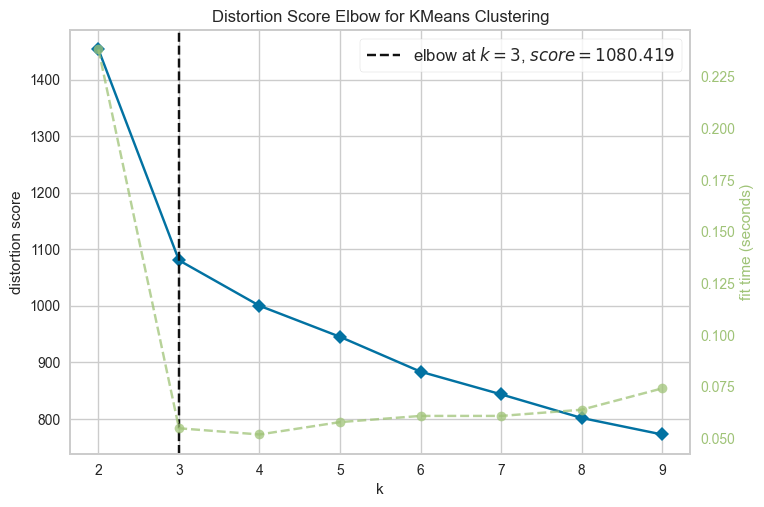

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
#Número óptimo de clusters
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')

X1 = X
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
visualizer.fit(X1)
visualizer.show()

Apoyándonos con kmeans, que es un método que requiere que le indiques el número de clusters, se puede observar que recomienda un número de 3 clusters, que coincide con la información de nuestro dataset, correspondiente a 3 tipos de vinos. Posteriormente se inicia el proceso de PCA

In [9]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Convert to data frame
principal_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])

# Componentes
print(principal_df.shape)
principal_df.head()

(161, 2)


,PC1,PC2
0,-3.503528,-1.609446
1,-2.342642,0.331164
2,-2.661349,-0.936183
3,-3.925301,-2.710827
4,-1.032831,-1.074396


En este caso se utilizarán dos componentes para representar la información y se colorearán dependiendo al cluster al que correspondan

In [12]:
# KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(X)

# Centroides de los clusters
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

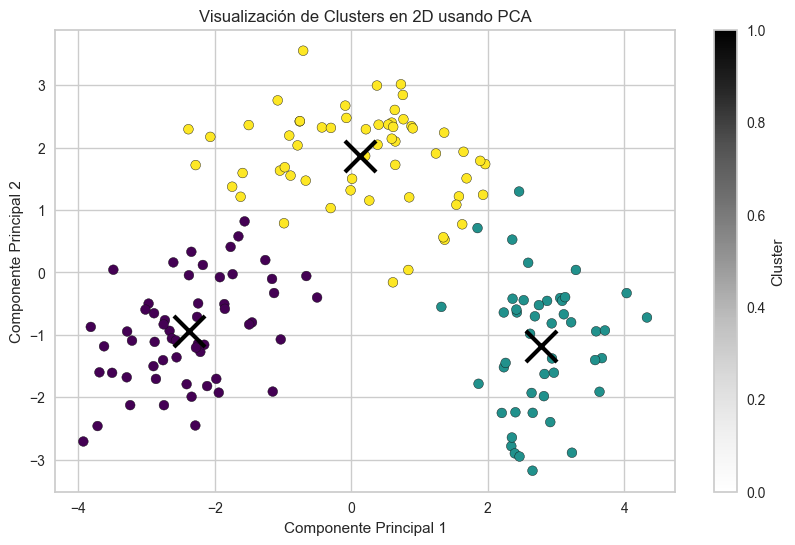

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k')
plt.scatter(x=centroids_pca[:,0], y=centroids_pca[:,1], marker="x", s=500, linewidths=3, color="black")
plt.title('Visualización de Clusters en 2D usando PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

Se puede observar claramente los 3 clusters separados y los componentes que mejor describe a cada uno.

In [14]:

pca = PCA(n_components=3)
components = pca.fit_transform(X)

# Gráfica 3D
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=clusters, size=0.1*np.ones(len(X)), opacity = 1,
    title='PCA plot in 3D',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=650, height=500
)
fig.show()

De igual manera con 3 componentes se puede observar claramente los 3 clusters separados y los componentes que mejor describe a cada uno.

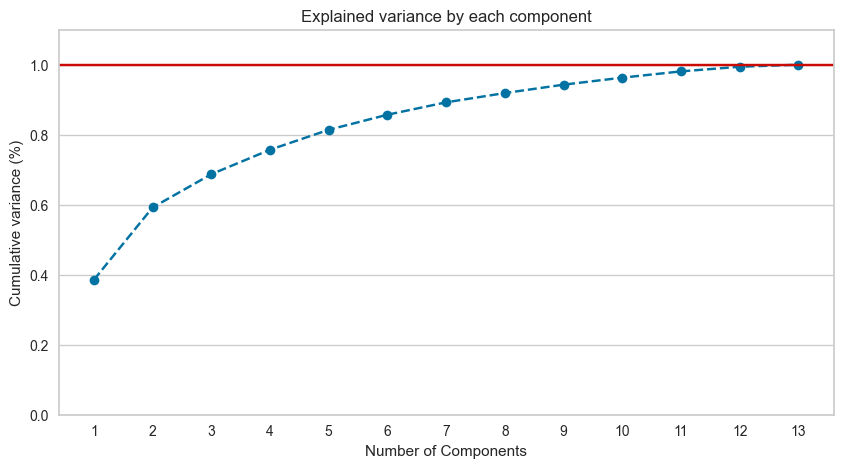

In [15]:
pca_var = PCA()
pca_var.fit(X)

# Graficar
plt.figure(figsize=(10,5))
xi = np.arange(1, 1+X.shape[1], step=1)
yi = np.cumsum(pca_var.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+X.shape[1], step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.gca().xaxis.grid(False)

Con la gráfica de la explicación de varianza se puede observar que al usaer 3 componentes se explica casi 2/3 de la base de datos, que considerando la reducción de dimensionalidad, es un buen porcentaje

# UMAP

Dejando de lado los proceso más clásicos para clusters y reducir dimensionalidaes como el PCA y kmeans, usaremos UMAP, que de igual manera va a reducir dimensionalidad, pero igual nos va a brindar una visualización de grafos conectados, que nos úede ser muy útil para obtener hallazgos de un análisis topológico

In [16]:
# UMAP
um = umap.UMAP()
X_fit = um.fit(X)
X_umap = um.transform(X)

# Guardar el umap en un dataframe
umap_df = pd.DataFrame(data = X_umap, columns = ['umap comp. 1', 'umap comp. 2'])

# Forma
print(umap_df.shape)
umap_df.head()

(161, 2)


,umap comp. 1,umap comp. 2
0,10.132556,3.078893
1,10.098187,4.658535
2,11.437482,3.997308
3,10.992873,3.014531
4,11.554201,5.161108


Text(0, 0.5, 'umap component 2')

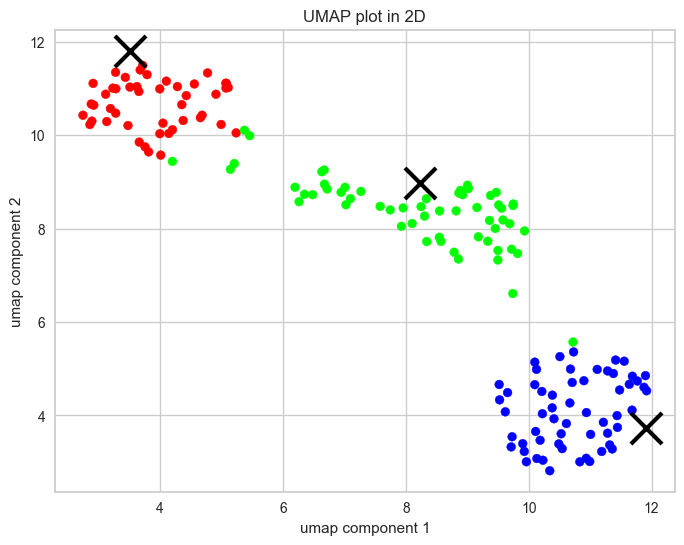

In [17]:
#Gráfica
plt.figure(figsize=(8,6))
plt.scatter(umap_df.iloc[:,0], umap_df.iloc[:,1], c=clusters, cmap="brg", s=40)
centroids_umap = um.transform(centroids)
plt.scatter(x=centroids_umap[:,0], y=centroids_umap[:,1], marker="x", s=500, linewidths=3, color="black")
plt.title('UMAP plot in 2D')
plt.xlabel('umap component 1')
plt.ylabel('umap component 2')

In [18]:
um = umap.UMAP(n_components=3)
components_umap = um.fit_transform(X)

# Gráfica 3D
fig = px.scatter_3d(
    components_umap, x=0, y=1, z=2, color=clusters, size=0.1*np.ones(len(X)), opacity = 1,
    title='UMAP plot in 3D',
    labels={'0': 'comp. 1', '1': 'comp. 2', '2': 'comp. 3'},
    width=650, height=500
)
fig.show()

Tanto en la gráfica 2D como 3D, podemos observar que el umap de igual manera logra separar los datos en clusters definidos, sin embargo, se pueden observar que los componentes que describen a estos clusters cambian a comparación de un PCA.

<AxesSubplot: >

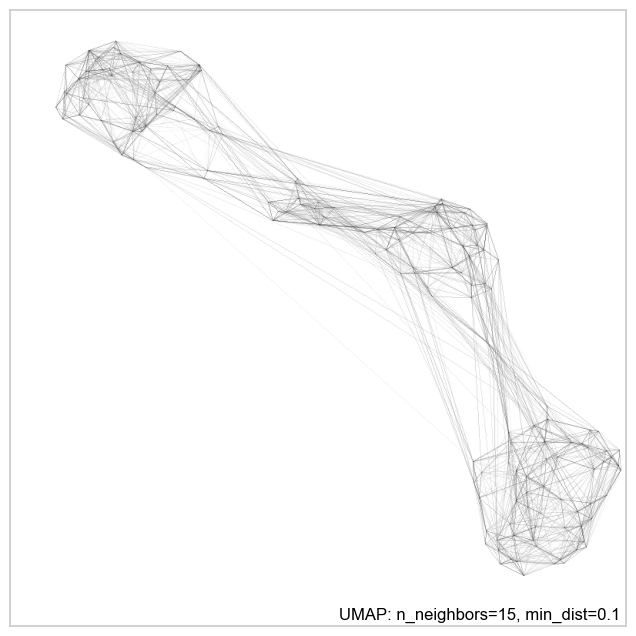

In [19]:
# Gráfica con conectividad de los puntos
umap.plot.connectivity(X_fit, show_points=True)

<AxesSubplot: >

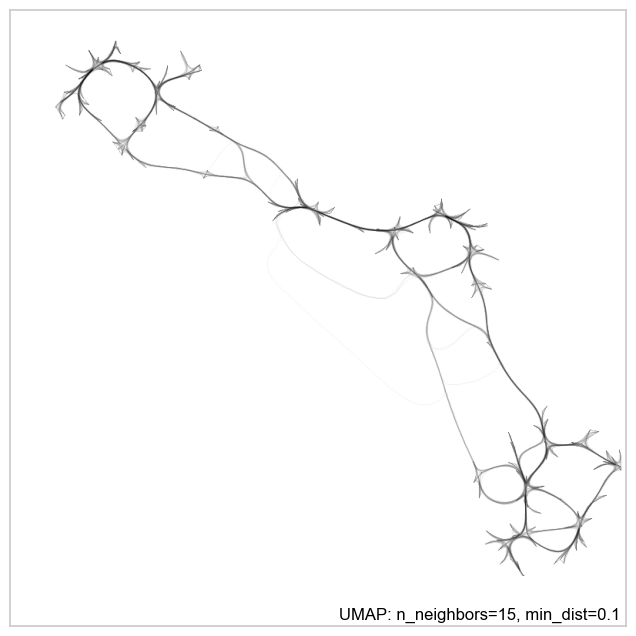

In [20]:
# Gráfica simplificada de las conexiones
umap.plot.connectivity(X_fit, show_points=True, edge_bundling='hammer')

Las dos gráficas anteriores nos son de gran ayuda para identificar que los datos correspondientes a cada cluster tienen relación, pero igual nos sirve para ver con que otros elementos a pesar de pertenecer a otro cluster tienen relación.

# Mapper

A diferencia de los métodos utilizados anteriormente, este es directamente relacionado con el TDA, por lo que nos ayudará a tener un punto de vista distinto y espermos sea de ayuda para obtener nuevos hallazgos

In [35]:
X.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,1.515163,-0.579166,0.270936,-1.248144,2.298023,0.828643,1.055948,-0.650569,1.466583,0.282097,0.383333,1.828097,0.982174
1,0.209648,-0.512507,-0.931537,-2.732175,0.114047,0.589411,0.749315,-0.815257,-0.505150,-0.304357,0.429479,1.096928,0.934830
2,0.158948,0.039806,1.266087,-0.236305,0.194935,0.828643,1.239928,-0.485881,2.481732,0.300715,0.337186,0.773526,1.360929
3,1.692612,-0.350622,0.561189,-0.843409,1.165591,2.503264,1.495455,-0.979945,1.251840,1.287448,-0.447308,1.167233,2.292034
4,0.260347,0.258826,2.095379,0.573166,1.570031,0.828643,0.677767,0.255215,0.549044,-0.332284,0.383333,0.436064,-0.059401


In [34]:
df_normalized = X.to_numpy()

### Visualización del mapper

In [80]:
warnings.filterwarnings('ignore')

mapper = km.KeplerMapper(verbose=1)

# La proyección sobre alcohol, corresponde a proyectar sobre la primera columna de data
projected_data = mapper.fit_transform(df_normalized, projection=[0], scaler=None) 

covering=km.Cover(n_cubes=10,perc_overlap=0.123)


G = mapper.map(projected_data, data, clusterer=sklearn.cluster.KMeans(n_clusters=3),cover=covering)

mapper.visualize(G, 
                path_html="mapper_visualization_output.html",
                 title="Mapper on Wine Data",
                #custom_tooltips = performance_data['gender'].to_numpy(),
                #color_values = mean,
                #color_function_name = 'Mean of Reading and Writing Score',
                node_color_function=np.array(['average','std','sum','max','min']))

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [0]
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (161, 13)

..Projecting data using: [0]
Mapping on data shaped (161, 13) using lens shaped (161, 1)

Creating 10 hypercubes.

Created 13 edges and 27 nodes in 0:00:00.467070.
Wrote visualization to: mapper_visualization_output.html


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Mapper on Wine Data | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13px;\n  font

### Análisis de los nodos

In [74]:
# Lista para almacenar los DataFrames de cada nodo
node_dfs = []

# Iterar sobre cada nodo en el grafo
for node, indices in G['nodes'].items():
    # Extraer los datos para este nodo utilizando los índices
    node_data = data.iloc[indices]
    
    # Añadir una columna indicando el ID del nodo
    node_data['node_id'] = node
    
    # Añadir el DataFrame del nodo a la lista
    node_dfs.append(node_data)

# Concatenar todos los DataFrames de los nodos en un único DataFrame
all_nodes_df = pd.concat(node_dfs, ignore_index=True)

# Ahora 'all_nodes_df' contiene todos los datos con una columna adicional 'node_id' que indica a qué nodo pertenecen
all_nodes_df.head()


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,node_id
0,11.66,1.88,1.92,16.0,97,1.61,1.57,0.34,1.15,3.80,1.23,2.14,428,cube0_cluster0
1,11.62,1.99,2.28,18.0,98,3.02,2.26,0.17,1.35,3.25,1.16,2.96,345,cube0_cluster0
2,11.41,0.74,2.50,21.0,88,2.48,2.01,0.42,1.44,3.08,1.10,2.31,434,cube0_cluster0
3,11.65,1.67,2.62,26.0,88,1.92,1.61,0.40,1.34,2.60,1.36,3.21,562,cube0_cluster1
4,11.76,2.68,2.92,20.0,103,1.75,2.03,0.60,1.05,3.80,1.23,2.50,607,cube0_cluster1


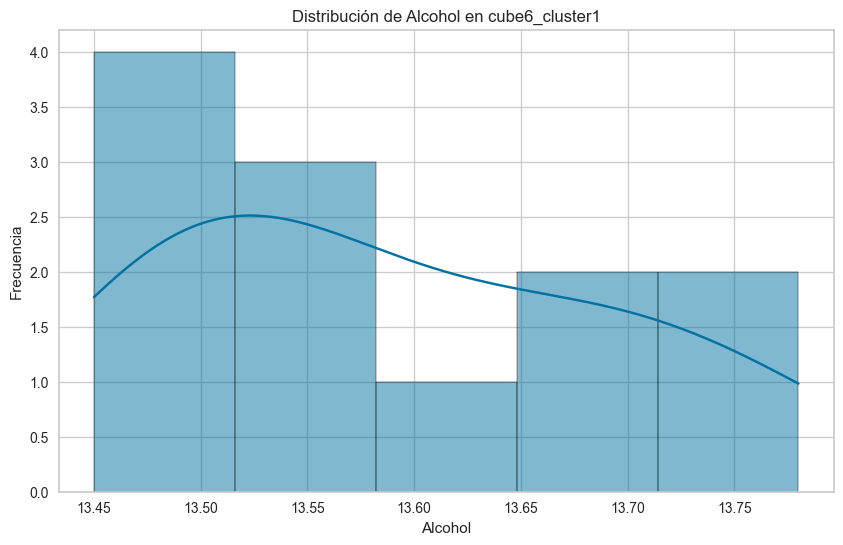

In [76]:
# Elegir un nodo específico para visualizar
node_id_to_visualize = 'cube6_cluster1'  # Ajusta esto según los IDs de tus nodos
node_data = all_nodes_df[all_nodes_df['node_id'] == node_id_to_visualize]

# Visualizar la distribución del 'Alcohol' en el nodo seleccionado
plt.figure(figsize=(10, 6))
sns.histplot(node_data['Alcohol'], kde=True)
plt.title(f'Distribución de Alcohol en {node_id_to_visualize}')
plt.xlabel('Alcohol')
plt.ylabel('Frecuencia')
plt.show()


En el gráfico anterior se puede observar cómo se ditribuye la variable alcohol y la frecuencia con la que aparece en los nodos

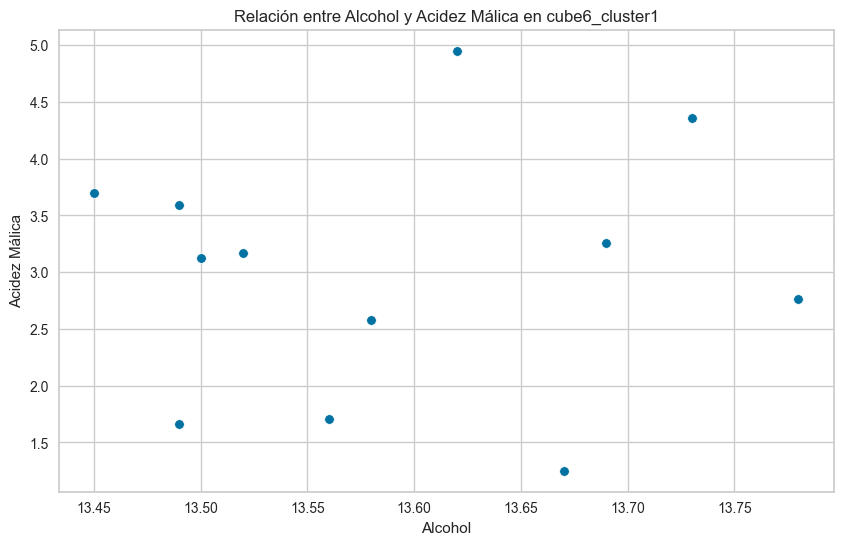

In [82]:
# Visualizar la relación entre 'Alcohol' y 'Malic acid'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Alcohol', y='Malic_Acid', data=node_data)
plt.title(f'Relación entre Alcohol y Acidez Málica en {node_id_to_visualize}')
plt.xlabel('Alcohol')
plt.ylabel('Acidez Málica')
plt.show()


En este gráfico se observa la relación entre el alcohol y la acidez máliza, que no aparenta haber alguna al menos en ese nodo

In [85]:
# Obtener los índices de los nodos especificados
indices_cube4_cluster0 = set(G['nodes']['cube4_cluster0'])
indices_cube5_cluster0 = set(G['nodes']['cube5_cluster0'])
indices_cube3_cluster2 = set(G['nodes']['cube3_cluster2'])
indices_cube0_cluster0 = set(G['nodes']['cube0_cluster0'])

# Encontrar elementos comunes
common_elements = indices_cube4_cluster0.intersection(
    indices_cube5_cluster0,
    indices_cube3_cluster2,
    indices_cube0_cluster0
)

print(f"Elementos comunes entre los nodos especificados: {common_elements}")


Elementos comunes entre los nodos especificados: set()


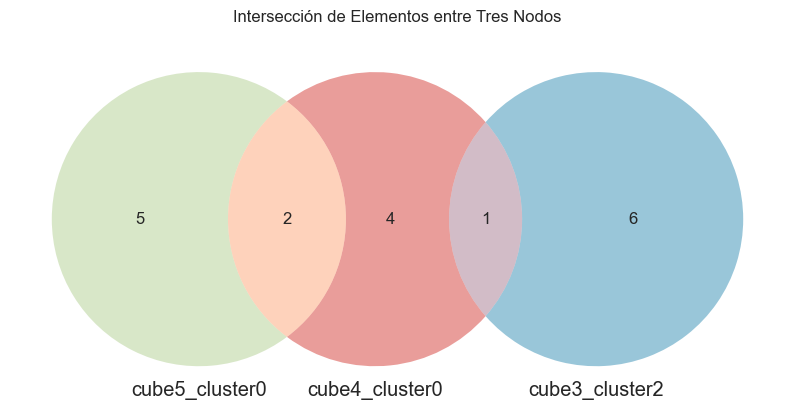

In [86]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Preparar los datos para el diagrama de Venn
venn_labels = {
    '100': len(indices_cube4_cluster0 - indices_cube5_cluster0 - indices_cube3_cluster2),
    '010': len(indices_cube5_cluster0 - indices_cube4_cluster0 - indices_cube3_cluster2),
    '001': len(indices_cube3_cluster2 - indices_cube4_cluster0 - indices_cube5_cluster0),
    '110': len(indices_cube4_cluster0 & indices_cube5_cluster0 - indices_cube3_cluster2),
    '101': len(indices_cube4_cluster0 & indices_cube3_cluster2 - indices_cube5_cluster0),
    '011': len(indices_cube5_cluster0 & indices_cube3_cluster2 - indices_cube4_cluster0),
    '111': len(indices_cube4_cluster0 & indices_cube5_cluster0 & indices_cube3_cluster2),
}

# Crear el diagrama de Venn
plt.figure(figsize=(10, 8))
venn3(subsets=venn_labels, set_labels=('cube4_cluster0', 'cube5_cluster0', 'cube3_cluster2'))
plt.title("Intersección de Elementos entre Tres Nodos")
plt.show()


En este gráfico de diagramas de Venn se puede observar con respecto a 3 nodos los elementos que tienen en común, que nos hacer referencia a que son similares